In [1]:
import folium
import geopandas as gpd


# Load boundary in WGS84
boundary = gpd.read_file("data/processed/st_thomas_boundary.geojson").to_crs("EPSG:4326")

# Project to a planar CRS (UTM zone 20N) to compute centroid accurately
boundary_proj = boundary.to_crs(epsg=32620)
ctr_proj = boundary_proj.geometry.centroid

# Transform centroid back to WGS84 for map center
ctr_wgs = gpd.GeoSeries(ctr_proj, crs=32620).to_crs(epsg=4326)
center_lat = ctr_wgs.y.mean()
center_lon = ctr_wgs.x.mean()

# Build the Folium map
f = folium.Figure(height=500)
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, control_scale=True).add_to(f)

# Esri Satellite basemap
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)

# Boundary overlay
folium.GeoJson(
    boundary.to_json(),
    name="Boundary",
    style_function=lambda x: {"color": "#DD6F78", "weight": 2, "fill": False},
).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Display 
m
m.save("vis/stthomas.html")

In [30]:
!pip install osmnx

import osmnx as ox
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

# Robust make_valid import
try:
    from shapely import make_valid
except ImportError:
    make_valid = lambda geom: geom.buffer(0)

# Paths and CRS
data_dir = Path("data")
processed = data_dir / "processed"
processed.mkdir(exist_ok=True)
target_crs = "EPSG:3857"

Original CRS: epsg:4326


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,query
0,"POLYGON ((-65.04213 18.35287, -65.04203 18.352...",18.383334,18.302428,-64.831785,-65.042129,281792257,relation,17825234,18.342908,-64.9189,place,island,17,0.54065,island,Saint Thomas,"Saint Thomas, Charlotte Amalie, Saint Thomas -...","St. Thomas, U.S. Virgin Islands"


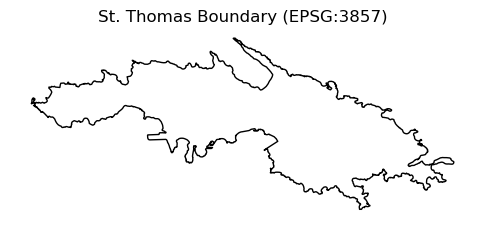

Saved boundary to: data\processed\st_thomas_boundary.geojson


In [31]:
# Try a few common place strings for St. Thomas
place_candidates = [
    "St. Thomas, U.S. Virgin Islands",
    "Saint Thomas, U.S. Virgin Islands",
    "St Thomas, U.S. Virgin Islands",
]

boundary = None
last_err = None
for place in place_candidates:
    try:
        gdf = ox.geocode_to_gdf(place)
        if not gdf.empty:
            gdf["query"] = place
            boundary = gdf
            break
    except Exception as e:
        last_err = e

if boundary is None:
    raise RuntimeError(f"Failed to fetch boundary. Last error: {last_err}")

# Inspect CRS and basic info
print("Original CRS:", boundary.crs)
display(boundary.head())

# Project to Web Mercator (EPSG:3857)
boundary_3857 = boundary.to_crs(target_crs)

# Plot projected boundary
ax = boundary_3857.plot(facecolor="none", edgecolor="black", figsize=(6, 6))
ax.set_title("St. Thomas Boundary (EPSG:3857)")
ax.set_axis_off()
plt.show()

# Save to processed folder
out_path = processed / "st_thomas_boundary.geojson"
boundary_3857.to_file(out_path, driver="GeoJSON")
print("Saved boundary to:", out_path)

In [32]:
import geopandas as gpd
from shapely.validation import make_valid  

# Load study area boundary and project to analysis CRS
boundary_fp = processed / "st_thomas_boundary.geojson"

# Read raw boundary 
boundary = gpd.read_file(boundary_fp)

# Project to target_crs 
boundary = boundary.to_crs(target_crs)

# Fix invalid geometries (self-intersections, slivers, etc.)
boundary["geometry"] = boundary.geometry.apply(make_valid)

# Drop empty / null geometries
boundary = boundary[
    boundary.geometry.notnull() & ~boundary.geometry.is_empty
]

# Dissolve all parts into a single study-area polygon
boundary["dissolve_id"] = 1  # same value for all rows
boundary_dissolved = boundary.dissolve(by="dissolve_id")

# Single Polygon (or MultiPolygon) object, useful for clip / Pandana bbox
boundary_union = boundary_dissolved.geometry.iloc[0]
boundary_single = gpd.GeoDataFrame(
    geometry=[boundary_union],
    crs=target_crs
)

print("Boundary rows (raw):", len(boundary))
print("Boundary union type:", boundary_union.geom_type)

Boundary rows (raw): 1
Boundary union type: Polygon



=== USVI_Flood_Zone.geojson ===
{'input_count': 2556, 'clipped_count': 499, 'crs': 'EPSG:3857', 'output': 'data\\processed\\flood_zone_st_thomas_3857.gpkg', 'columns': ['FID', 'FLD_ZONE', 'ST_BFE_ft', 'V_DATUM', 'FZn_ID', 'Depth_ft', 'ZONE_SUBTY', 'SHAPE_Leng', 'Shape__Are', 'Shape__Len', 'FldZone', 'SqMi', 'Shape__Area', 'Shape__Length', 'geometry']}


,FID,FLD_ZONE,ST_BFE_ft,V_DATUM,FZn_ID,Depth_ft,ZONE_SUBTY,SHAPE_Leng,Shape__Are,Shape__Len,FldZone,SqMi,Shape__Area,Shape__Length,geometry
670,671,VE,13,VIVD09,715,-9999,NP,2082.678017,1.513524e-06,0.005910,VE,0.001142,2958.866089,601.445928,"POLYGON ((-7224535.691 2073895.866, -7224528.0..."
697,698,VE,14,VIVD09,742,-9999,NP,1923.031176,1.294365e-06,0.005437,VE,0.000371,961.702705,298.784691,"POLYGON ((-7224753.339 2073945.558, -7224750.2..."
645,646,VE,12,VIVD09,690,-9999,NP,1356.843890,3.245918e-07,0.003876,VE,0.001466,3798.096886,413.566644,"POLYGON ((-7224687.595 2073988.764, -7224677.3..."
700,701,VE,14,VIVD09,745,-9999,NP,3733.978623,3.411003e-06,0.010518,VE,0.001119,2898.196648,843.660651,"MULTIPOLYGON (((-7224461.817 2073835.215, -722..."
698,699,VE,14,VIVD09,743,-9999,NP,5286.739577,8.511948e-06,0.015016,VE,0.000508,1316.357071,494.256287,"MULTIPOLYGON (((-7225275.474 2073959.869, -722..."


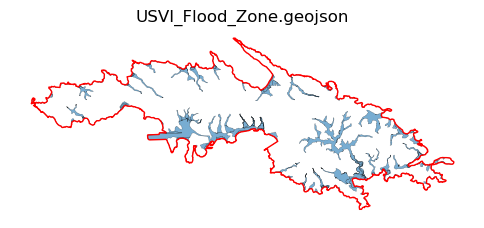


=== USVI_Tsunami.geojson ===
{'input_count': 73, 'clipped_count': 1, 'crs': 'EPSG:3857', 'output': 'data\\processed\\tsunami_st_thomas_3857.gpkg', 'columns': ['FID', 'Id', 'Shape__Area', 'Shape__Length', 'geometry']}


,FID,Id,Shape__Area,Shape__Length,geometry
21,22,0,1.082695e+07,217385.934245,"MULTIPOLYGON (((-7226335.668 2074755.905, -722..."


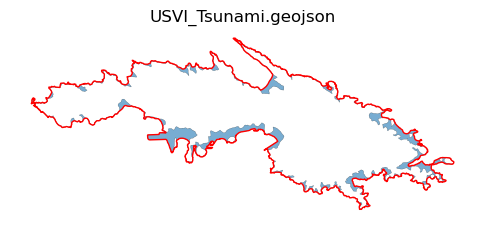


=== USVI_Ghuts.geojson ===
{'input_count': 448, 'clipped_count': 115, 'crs': 'EPSG:3857', 'output': 'data\\processed\\ghuts_st_thomas_3857.gpkg', 'columns': ['FID', 'FNODE_', 'TNODE_', 'LPOLY_', 'RPOLY_', 'LENGTH', 'STREAMS_', 'STREAMS_ID', 'Island', 'Shape__Length', 'geometry']}


,FID,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,STREAMS_,STREAMS_ID,Island,Shape__Length,geometry
101,102,0,0,0,0,0.0,0,0,,249.451041,"LINESTRING (-7224823.497 2074305.375, -7224933..."
99,100,0,0,0,0,0.0,0,0,,425.691525,"LINESTRING (-7223893.550 2074548.622, -7223888..."
102,103,0,0,0,0,0.0,0,0,,269.437508,"LINESTRING (-7225779.508 2074776.958, -7225913..."
148,149,0,0,0,0,0.0,0,0,,614.123222,"LINESTRING (-7223042.216 2075060.981, -7223040..."
105,106,0,0,0,0,0.0,0,0,,511.166993,"LINESTRING (-7225742.494 2075059.382, -7225772..."


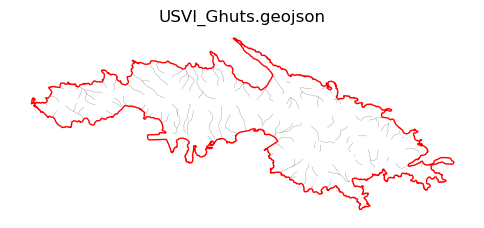


=== LandCover.geojson ===
{'input_count': 5620, 'clipped_count': 1952, 'crs': 'EPSG:3857', 'output': 'data\\processed\\landcover_st_thomas_3857.gpkg', 'columns': ['FID', 'OBJECTID', 'class', 'ORIG_FID', 'area', 'SHAPE_Leng', 'Shape__Area', 'Shape__Length', 'geometry']}


,FID,OBJECTID,class,ORIG_FID,area,SHAPE_Leng,Shape__Area,Shape__Length,geometry
5240,5241,5241,Shrub,12,0.031451,92.578198,281.942528,87.561300,"POLYGON ((-7224357.564 2073958.991, -7224357.5..."
3746,3747,3747,Forest,8,0.008975,46.019746,80.457115,43.590177,"POLYGON ((-7224615.736 2073975.853, -7224630.5..."
5394,5395,5395,Water,13,0.012628,70.897217,113.198509,67.288714,"MULTIPOLYGON (((-7224003.406 2074057.871, -722..."
3748,3749,3749,Forest,8,0.028330,74.348617,253.959190,70.390788,"POLYGON ((-7224048.090 2074067.091, -7224069.4..."
5395,5396,5396,Water,13,0.005737,37.745166,51.429977,35.767834,"POLYGON ((-7223953.476 2074081.683, -7223953.5..."


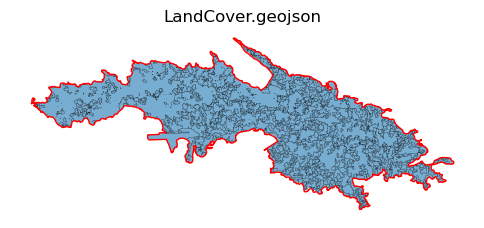


=== BuildingFootprints.geojson ===
{'input_count': 44710, 'clipped_count': 16004, 'crs': 'EPSG:3857', 'output': 'data\\processed\\buildings_st_thomas_3857.gpkg', 'columns': ['FID', 'Class', 'Confidence', 'ORIG_OID', 'STATUS', 'Shape__Area', 'Shape__Length', 'geometry']}


,FID,Class,Confidence,ORIG_OID,STATUS,Shape__Area,Shape__Length,geometry
5247,5248,,0.0,0,0,214.084778,63.633547,"POLYGON ((-7222789.340 2074812.204, -7222791.5..."
5406,5407,,0.0,0,0,270.323380,73.532001,"POLYGON ((-7223064.401 2074235.599, -7223079.2..."
5394,5395,,0.0,0,0,76.485504,36.766046,"POLYGON ((-7223145.843 2074313.638, -7223133.2..."
5389,5390,,0.0,0,0,69.986320,36.058936,"POLYGON ((-7223130.951 2074330.540, -7223131.6..."
5395,5396,,0.0,0,0,140.973251,49.492848,"POLYGON ((-7222931.932 2074336.211, -7222920.2..."


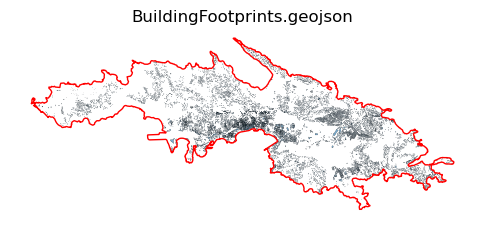


=== parcel_value.geojson ===
{'input_count': 24091, 'clipped_count': 23610, 'crs': 'EPSG:3857', 'output': 'data\\processed\\parcel_value_st_thomas_3857.gpkg', 'columns': ['DPNR_ZONE', 'PARCEL_NO', 'MAP', 'PARCEL_NAM', 'ACRE', 'LONGITUDE', 'LATITUDE', 'OBJECTID_1', 'PARCEL_NO_', 'Tax_Legal_', 'Name', 'Address', 'City', 'State', 'Zip', 'Country', 'Land_Value', 'Improved_V', 'created_us', 'created_da', 'last_edite', 'last_edi_1', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']}


,DPNR_ZONE,PARCEL_NO,MAP,PARCEL_NAM,ACRE,LONGITUDE,LATITUDE,OBJECTID_1,PARCEL_NO_,Tax_Legal_,...,Country,Land_Value,Improved_V,created_us,created_da,last_edite,last_edi_1,SHAPE_Leng,SHAPE_Area,geometry
1673,R-1,109701010800,D9-8000-T007,8-12,.90,-64.845454,18.311844,42255,109701010800,8-12&8-13 ESTATE NAZARETH 1 RED HOOK,...,United States,575500,102000,NaN,NaN,NaN,NaN,327.389648,3024.317162,"POLYGON ((-7218569.618 2074067.181, -7218572.8..."
1672,R-1,109701010800,D9-8000-T007,8-13,.72,-64.845681,18.312024,42255,109701010800,8-12&8-13 ESTATE NAZARETH 1 RED HOOK,...,United States,575500,102000,NaN,NaN,NaN,NaN,236.365302,2395.937798,"POLYGON ((-7218623.569 2074080.214, -7218624.7..."
1482,R-1,109701010700,A9-35-T65,8-14,NaN,-64.845879,18.312255,42254,109701010700,8-14 ESTATE NAZARETH RED HOOK QTR,...,United States,541000,1200000,NaN,NaN,NaN,NaN,192.280658,1924.277732,"POLYGON ((-7218589.954 2074123.106, -7218624.7..."
1480,R-1,109701011000,A3-35-T65,8-11,NaN,-64.845177,18.312358,42256,109701011000,8-11 ESTATE NAZARETH No.1 RED HOOK QTR.,...,United States,399200,1309700,NaN,NaN,NaN,NaN,224.985190,2455.835935,"POLYGON ((-7218510.139 2074140.062, -7218512.6..."
1478,R-1,109701010600,NaN,NaN,NaN,-64.846262,18.312598,42253,109701010600,8-15 ESTATE NAZARETH RED HOOK QTR,...,United States,485700,695700,NaN,NaN,NaN,NaN,230.324864,1535.526928,"POLYGON ((-7218626.461 2074150.406, -7218629.8..."


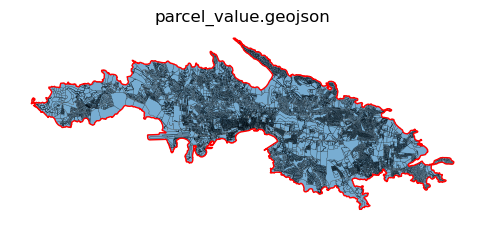


Done. Summary:
USVI_Flood_Zone.geojson {'input_count': 2556, 'clipped_count': 499, 'crs': 'EPSG:3857', 'output': 'data\\processed\\flood_zone_st_thomas_3857.gpkg', 'columns': ['FID', 'FLD_ZONE', 'ST_BFE_ft', 'V_DATUM', 'FZn_ID', 'Depth_ft', 'ZONE_SUBTY', 'SHAPE_Leng', 'Shape__Are', 'Shape__Len', 'FldZone', 'SqMi', 'Shape__Area', 'Shape__Length', 'geometry']}
USVI_Tsunami.geojson {'input_count': 73, 'clipped_count': 1, 'crs': 'EPSG:3857', 'output': 'data\\processed\\tsunami_st_thomas_3857.gpkg', 'columns': ['FID', 'Id', 'Shape__Area', 'Shape__Length', 'geometry']}
USVI_Ghuts.geojson {'input_count': 448, 'clipped_count': 115, 'crs': 'EPSG:3857', 'output': 'data\\processed\\ghuts_st_thomas_3857.gpkg', 'columns': ['FID', 'FNODE_', 'TNODE_', 'LPOLY_', 'RPOLY_', 'LENGTH', 'STREAMS_', 'STREAMS_ID', 'Island', 'Shape__Length', 'geometry']}
LandCover.geojson {'input_count': 5620, 'clipped_count': 1952, 'crs': 'EPSG:3857', 'output': 'data\\processed\\landcover_st_thomas_3857.gpkg', 'columns': ['

In [33]:
from shapely import make_valid

def safe_make_valid(geom):
    if geom is None:
        return None
    try:
        if geom.is_valid:
            return geom
        return make_valid(geom)
    except Exception:
        return None

# Define layers to process: input filename -> output filename
layers = {
    "USVI_Flood_Zone.geojson": "flood_zone_st_thomas_3857.gpkg",
    "USVI_Tsunami.geojson": "tsunami_st_thomas_3857.gpkg",
    "USVI_Ghuts.geojson": "ghuts_st_thomas_3857.gpkg",
    "LandCover.geojson": "landcover_st_thomas_3857.gpkg",
    "BuildingFootprints.geojson": "buildings_st_thomas_3857.gpkg",
    "parcel_value.geojson": "parcel_value_st_thomas_3857.gpkg",
}

summary = {}

for fname, outname in layers.items():
    fpath = data_dir / fname
    gdf = gpd.read_file(fpath)

    # If CRS missing, assume WGS84
    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")

    # Reproject to target CRS
    gdf = gdf.to_crs(target_crs)

    # Drop null geometries, fix geometries, drop empties
    gdf = gdf.dropna(subset=["geometry"]).copy()
    gdf["geometry"] = gdf.geometry.apply(safe_make_valid)
    gdf = gdf.dropna(subset=["geometry"])
    gdf = gdf[~gdf.geometry.is_empty]

    # Clip to boundary
    clipped = gdf.clip(boundary_union)
    clipped = clipped[~clipped.geometry.is_empty]

    # Save
    out_path = processed / outname
    clipped.to_file(out_path, driver="GPKG")

    # Record summary
    summary[fname] = {
        "input_count": len(gdf),
        "clipped_count": len(clipped),
        "crs": str(gdf.crs),
        "output": str(out_path),
        "columns": list(clipped.columns),
    }

    # Preview head and plot
    print(f"\n=== {fname} ===")
    print(summary[fname])
    display(clipped.head())

    ax = clipped.plot(figsize=(6, 6), alpha=0.6, edgecolor="k", linewidth=0.2)
    boundary.boundary.plot(ax=ax, color="red", linewidth=1)
    ax.set_title(f"{fname}")
    ax.set_axis_off()
    plt.show()

print("\nDone. Summary:")
for k, v in summary.items():
    print(k, v)



=== parcel_value.geojson ===
{'input_count': 24091, 'clipped_count': 23610, 'crs': 'EPSG:3857', 'output': 'data\\processed\\parcel_value_st_thomas_3857.gpkg', 'columns': ['DPNR_ZONE', 'PARCEL_NO', 'MAP', 'PARCEL_NAM', 'ACRE', 'LONGITUDE', 'LATITUDE', 'OBJECTID_1', 'PARCEL_NO_', 'Tax_Legal_', 'Name', 'Address', 'City', 'State', 'Zip', 'Country', 'Land_Value', 'Improved_V', 'created_us', 'created_da', 'last_edite', 'last_edi_1', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']}


,DPNR_ZONE,PARCEL_NO,MAP,PARCEL_NAM,ACRE,LONGITUDE,LATITUDE,OBJECTID_1,PARCEL_NO_,Tax_Legal_,...,Country,Land_Value,Improved_V,created_us,created_da,last_edite,last_edi_1,SHAPE_Leng,SHAPE_Area,geometry
1673,R-1,109701010800,D9-8000-T007,8-12,.90,-64.845454,18.311844,42255,109701010800,8-12&8-13 ESTATE NAZARETH 1 RED HOOK,...,United States,575500,102000,NaN,NaN,NaN,NaN,327.389648,3024.317162,"POLYGON ((-7218569.618 2074067.181, -7218572.8..."
1672,R-1,109701010800,D9-8000-T007,8-13,.72,-64.845681,18.312024,42255,109701010800,8-12&8-13 ESTATE NAZARETH 1 RED HOOK,...,United States,575500,102000,NaN,NaN,NaN,NaN,236.365302,2395.937798,"POLYGON ((-7218623.569 2074080.214, -7218624.7..."
1482,R-1,109701010700,A9-35-T65,8-14,NaN,-64.845879,18.312255,42254,109701010700,8-14 ESTATE NAZARETH RED HOOK QTR,...,United States,541000,1200000,NaN,NaN,NaN,NaN,192.280658,1924.277732,"POLYGON ((-7218589.954 2074123.106, -7218624.7..."
1480,R-1,109701011000,A3-35-T65,8-11,NaN,-64.845177,18.312358,42256,109701011000,8-11 ESTATE NAZARETH No.1 RED HOOK QTR.,...,United States,399200,1309700,NaN,NaN,NaN,NaN,224.985190,2455.835935,"POLYGON ((-7218510.139 2074140.062, -7218512.6..."
1478,R-1,109701010600,NaN,NaN,NaN,-64.846262,18.312598,42253,109701010600,8-15 ESTATE NAZARETH RED HOOK QTR,...,United States,485700,695700,NaN,NaN,NaN,NaN,230.324864,1535.526928,"POLYGON ((-7218626.461 2074150.406, -7218629.8..."


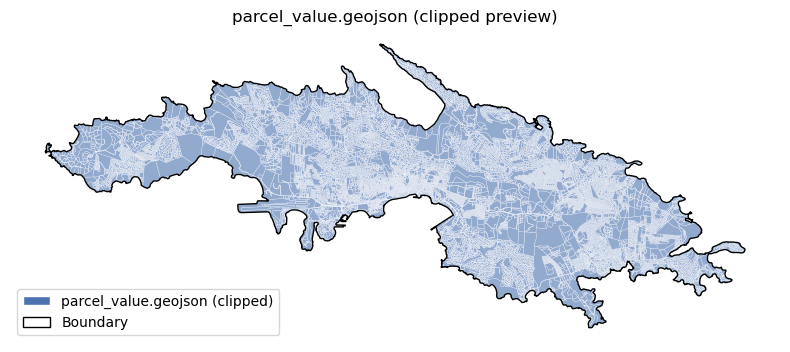

In [34]:
from matplotlib import patches as mpatches

# Preview head and plot
print(f"\n=== {fname} ===")
print(summary[fname])
display(clipped.head())

fig, ax = plt.subplots(figsize=(8, 10))

boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Boundary")
clipped.plot(
    ax=ax,
    color="#4c72b0",        
    alpha=0.6,
    edgecolor="white",
    linewidth=0.3,
    label=f"{fname} (clipped)",
)

ax.set_title(f"{fname} (clipped preview)")
ax.set_axis_off()

legend_patches = [
    mpatches.Patch(facecolor="#4c72b0", edgecolor="white", label=f"{fname} (clipped)"),
    mpatches.Patch(facecolor="none", edgecolor="black", label="Boundary"),
]
ax.legend(handles=legend_patches, loc="lower left")

plt.tight_layout()
plt.show()

In [35]:
!pip install rasterio

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import make_valid
import rasterio 
from rasterio import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from scipy.ndimage import distance_transform_edt

In [36]:
# Paths/CRS
data_dir = Path("data")
dem_dir = data_dir / "USVI-St Thomas dem"
processed = data_dir / "processed"
processed.mkdir(exist_ok=True)
target_crs = "EPSG:3857"

# Ghuts (processed vector)
ghuts = gpd.read_file(processed / "ghuts_st_thomas_3857.gpkg").to_crs(target_crs)
ghuts["geometry"] = ghuts.geometry.apply(make_valid)
ghuts = ghuts[~ghuts.geometry.is_empty]

In [37]:
# Reproject DEM to EPSG:3857
src_dem_path = data_dir / "USVI_DEM.tif"
with rasterio.open(src_dem_path) as src:
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    dst_meta = src.meta.copy()
    dst_meta.update({
        "crs": target_crs,
        "transform": dst_transform,
        "width": dst_width,
        "height": dst_height,
        "nodata": src.nodata,
    })
    dem_reproj_path = processed / "dem_3857.tif"
    with rasterio.open(dem_reproj_path, "w", **dst_meta) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear,
            )
print("Saved reprojected DEM:", dem_reproj_path)

Saved reprojected DEM: data\processed\dem_3857.tif


In [38]:
# Clip DEM to boundary
with rasterio.open(dem_reproj_path) as src:
    dem_clip, dem_clip_transform = mask(
        src, [boundary_union], crop=True, all_touched=True, filled=False
    )
    dem_clip_meta = src.meta.copy()
    dem_clip_meta.update({
        "height": dem_clip.shape[1],
        "width": dem_clip.shape[2],
        "transform": dem_clip_transform,
    })
dem_clip_path = processed / "dem_st_thomas_3857.tif"
with rasterio.open(dem_clip_path, "w", **dem_clip_meta) as dst:
    dst.write(dem_clip)
print("Saved clipped DEM:", dem_clip_path)

Saved clipped DEM: data\processed\dem_st_thomas_3857.tif


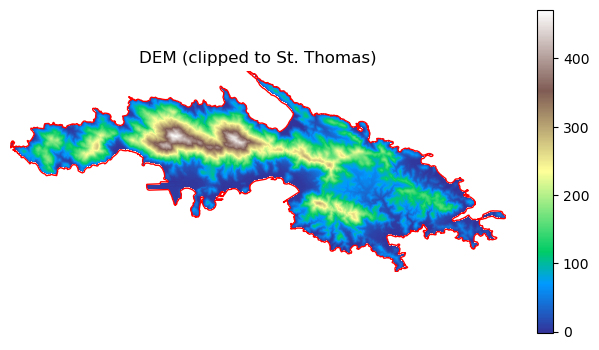

In [39]:
import numpy as np

# Preview clipped DEM
dem_data = dem_clip[0]
fig, ax = plt.subplots(figsize=(8, 6))

left = dem_clip_transform.c
top = dem_clip_transform.f
right = left + dem_clip.shape[2] * dem_clip_transform.a
bottom = top + dem_clip.shape[1] * dem_clip_transform.e

img = ax.imshow(
    dem_data,
    extent=(left, right, bottom, top),
    cmap="terrain",
    origin="upper"
)

boundary.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("DEM (clipped to St. Thomas)")
ax.set_axis_off()
plt.colorbar(img, ax=ax, shrink=0.7)
plt.show()

In [40]:
# Slope (degrees)
with rasterio.open(dem_clip_path) as src:
    dem = src.read(1).astype("float32")
    transform = src.transform
    nodata = src.nodata

px = transform.a
py = -transform.e
dy, dx = np.gradient(dem, py, px)
slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
slope_deg = np.degrees(slope_rad)

if nodata is not None:
    slope_deg[dem == nodata] = np.nan

slope_meta = dem_clip_meta.copy()
slope_meta.update({"dtype": "float32", "count": 1, "nodata": np.nan})
slope_path = processed / "slope_degrees_3857.tif"
with rasterio.open(slope_path, "w", **slope_meta) as dst:
    dst.write(slope_deg.astype("float32"), 1)
print("Saved slope raster:", slope_path)

C:\Users\lucyf\AppData\Local\Temp\ipykernel_5256\2884367153.py:10: RuntimeWarning: overflow encountered in square
  slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))


Saved slope raster: data\processed\slope_degrees_3857.tif


In [41]:
# Ghut distance (meters) on DEM grid
with rasterio.open(dem_clip_path) as src:
    out_shape = (src.height, src.width)
    out_transform = src.transform

ghut_mask = rasterize(
    [(geom, 1) for geom in ghuts.geometry],
    out_shape=out_shape,
    transform=out_transform,
    fill=0,
    dtype="uint8",
    all_touched=True,
)

dist_pixels = distance_transform_edt(ghut_mask == 0)
pixel_size = (abs(out_transform.a) + abs(out_transform.e)) / 2.0
dist_meters = dist_pixels * pixel_size

# Clamp to 0–1000 m
dist_meters = np.clip(dist_meters, 0, 1000)

# Classify into 200 m bins (0-200-400-600-800-1000)
# bins = [0, 200, 400, 600, 800, 1000]
# dist_binned = np.digitize(dist_meters, bins, right=True)

dist_meta = dem_clip_meta.copy()
dist_meta.update({"dtype": "float32", "count": 1, "nodata": np.nan})
dist_path = processed / "ghut_distance_m_3857.tif"
with rasterio.open(dist_path, "w", **dist_meta) as dst:
    dst.write(dist_meters.astype("float32"), 1)
print("Saved ghut distance raster:", dist_path)

Saved ghut distance raster: data\processed\ghut_distance_m_3857.tif


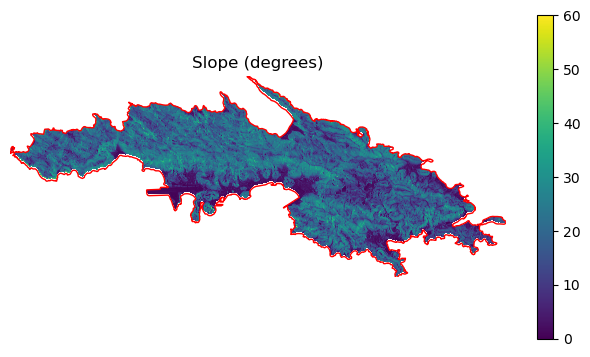

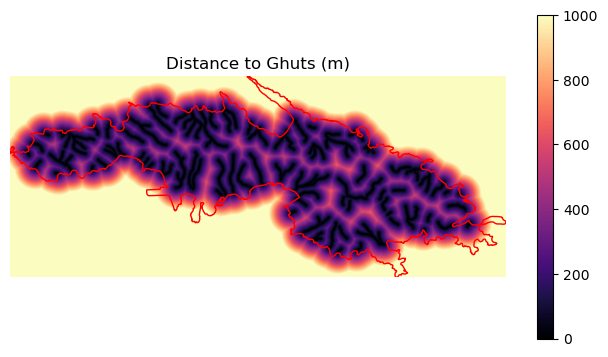

In [42]:
# Quick previews
def plot_raster(path, title, cmap="terrain", vmin=None, vmax=None):
    with rasterio.open(path) as src:
        arr = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(arr, extent=extent, origin="upper", cmap=cmap, vmin=vmin, vmax=vmax)
    boundary.boundary.plot(ax=ax, color="red", linewidth=1)
    ax.set_title(title)
    ax.set_axis_off()
    plt.colorbar(img, ax=ax, shrink=0.7)
    plt.show()

plot_raster(slope_path, "Slope (degrees)", cmap="viridis", vmin=0, vmax=60)
plot_raster(dist_path, "Distance to Ghuts (m)", cmap="magma")


=== OSM Roads ===
edges in graph: 5526, clipped: 5526
output: data\processed\roads_st_thomas_3857.gpkg


,highway,name,length,oneway,geometry
0,residential,NaN,1142.816,False,"LINESTRING (-7221794.547 2073225.892, -7221936..."
1,residential,NaN,1142.816,False,"LINESTRING (-7222431.840 2073836.435, -7222423..."
2,trunk,"Nicholas ""Nick"" Friday Memorial Drive",762.867,False,"LINESTRING (-7221993.274 2075018.761, -7221986..."
3,trunk,"Nicholas ""Nick"" Friday Memorial Drive",762.867,False,"LINESTRING (-7221590.364 2074955.005, -7221589..."
4,residential,Nadir Hill Road,476.211,False,"LINESTRING (-7221953.155 2075028.974, -7221933..."


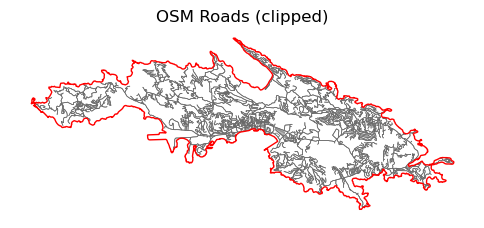

In [43]:
import osmnx as ox
import geopandas as gpd
from shapely import make_valid
import matplotlib.pyplot as plt

target_crs = "EPSG:3857"

# Boundary to WGS84 for OSM, then project roads back to target CRS
boundary_wgs_poly = gpd.GeoSeries([boundary_union], crs=boundary.crs).to_crs(4326).iloc[0]
G = ox.graph_from_polygon(boundary_wgs_poly, network_type="drive")
G = ox.project_graph(G, to_crs=target_crs)

# Extract edges, fix geometry, clip to boundary
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges["geometry"] = edges.geometry.apply(make_valid)
edges = edges[~edges.geometry.is_empty]

roads_clipped = edges.clip(boundary_union)
roads_clipped = roads_clipped[~roads_clipped.geometry.is_empty].reset_index(drop=True)

# Keep only a few safe fields; convert object/list/dict to string
allowed_cols = ["highway", "name", "length", "oneway", "geometry"]
roads_clipped = roads_clipped[[c for c in allowed_cols if c in roads_clipped.columns]].copy()

for col in roads_clipped.columns:
    if roads_clipped[col].dtype == object:
        roads_clipped[col] = roads_clipped[col].apply(
            lambda v: str(v) if isinstance(v, (list, dict)) else v
        )

# Save
roads_out = processed / "roads_st_thomas_3857.gpkg"
roads_clipped.to_file(roads_out, driver="GPKG")

print(f"\n=== OSM Roads ===")
print(f"edges in graph: {len(edges)}, clipped: {len(roads_clipped)}")
print(f"output: {roads_out}")
display(roads_clipped.head())

# Preview
ax = roads_clipped.plot(figsize=(6, 6), linewidth=0.5, color="dimgray")
boundary.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("OSM Roads (clipped)")
ax.set_axis_off()
plt.show()


In [44]:
from shapely import make_valid

# Load and project
shelters = gpd.read_file(data_dir / "Shelter.geojson").to_crs(target_crs)
shelters["geometry"] = shelters.geometry.apply(make_valid)
shelters = shelters[~shelters.geometry.is_empty]

# Clip to boundary (boundary/ boundary_union already in target_crs)
shelters = gpd.clip(shelters, boundary_union)
shelters = shelters[~shelters.geometry.is_empty]

# IDs/names
if "shelter_id" not in shelters.columns:
    shelters["shelter_id"] = shelters.index.astype(str)
if "name" not in shelters.columns:
    shelters["name"] = shelters.index.astype(str)

print("Shelters after clip:", shelters.shape)
shelters.head()

Shelters after clip: (6, 8)


,FID,Name,Latitude,Longitude,Island,geometry,shelter_id,name
5,5,Bertha B. Boschulte School,18.317206,-64.891119,St.Thomas,POINT (-7223646.324 2074710.573),5,5
0,0,Sugar Estate Head Start Center,18.339801,-64.920562,St.Thomas,POINT (-7226923.904 2077360.258),0,0
1,1,Community Health Clinic at Schneider,18.340168,-64.914869,St.Thomas,POINT (-7226290.162 2077403.298),1,1
4,4,Charlotte Amalie High School Auditorium,18.341186,-64.919949,St.Thomas,POINT (-7226855.665 2077522.686),4,4
2,2,Lockhart Elementary,18.341674,-64.916455,St.Thomas,POINT (-7226466.715 2077579.917),2,2



=== OSM Roads ===
edges in graph: 5526, clipped: 5526
output: data\processed\roads_st_thomas_3857.gpkg


,highway,name,length,oneway,geometry
0,residential,NaN,1142.816,False,"LINESTRING (-7221794.547 2073225.892, -7221936..."
1,residential,NaN,1142.816,False,"LINESTRING (-7222431.840 2073836.435, -7222423..."
2,trunk,"Nicholas ""Nick"" Friday Memorial Drive",762.867,False,"LINESTRING (-7221993.274 2075018.761, -7221986..."
3,trunk,"Nicholas ""Nick"" Friday Memorial Drive",762.867,False,"LINESTRING (-7221590.364 2074955.005, -7221589..."
4,residential,Nadir Hill Road,476.211,False,"LINESTRING (-7221953.155 2075028.974, -7221933..."


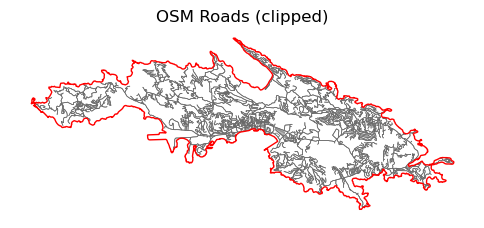

In [25]:
import osmnx as ox
import geopandas as gpd
from shapely import make_valid
import matplotlib.pyplot as plt

target_crs = "EPSG:3857"

# 1) Boundary to WGS84 for OSM, then project roads back to target CRS
boundary_wgs_poly = gpd.GeoSeries([boundary_union], crs=boundary.crs).to_crs(4326).iloc[0]
G = ox.graph_from_polygon(boundary_wgs_poly, network_type="drive")
G = ox.project_graph(G, to_crs=target_crs)

# 2) Extract edges, fix geometry, clip to boundary
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges["geometry"] = edges.geometry.apply(make_valid)
edges = edges[~edges.geometry.is_empty]

roads_clipped = edges.clip(boundary_union)
roads_clipped = roads_clipped[~roads_clipped.geometry.is_empty].reset_index(drop=True)

# 3) Keep only writable fields; convert list/dict to string
allowed_cols = ["highway", "name", "length", "oneway", "geometry"]
roads_clipped = roads_clipped[[c for c in allowed_cols if c in roads_clipped.columns]].copy()

for col in roads_clipped.columns:
    if roads_clipped[col].dtype == object:
        roads_clipped[col] = roads_clipped[col].apply(
            lambda v: str(v) if isinstance(v, (list, dict)) else v
        )

# 4) Save
roads_out = processed / "roads_st_thomas_3857.gpkg"
roads_clipped.to_file(roads_out, driver="GPKG")

print(f"\n=== OSM Roads ===")
print(f"edges in graph: {len(edges)}, clipped: {len(roads_clipped)}")
print(f"output: {roads_out}")
display(roads_clipped.head())

# 5) Preview
ax = roads_clipped.plot(figsize=(6, 6), linewidth=0.5, color="dimgray")
boundary.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("OSM Roads (clipped)")
ax.set_axis_off()
plt.show()


Saved plot to images\datasource.png


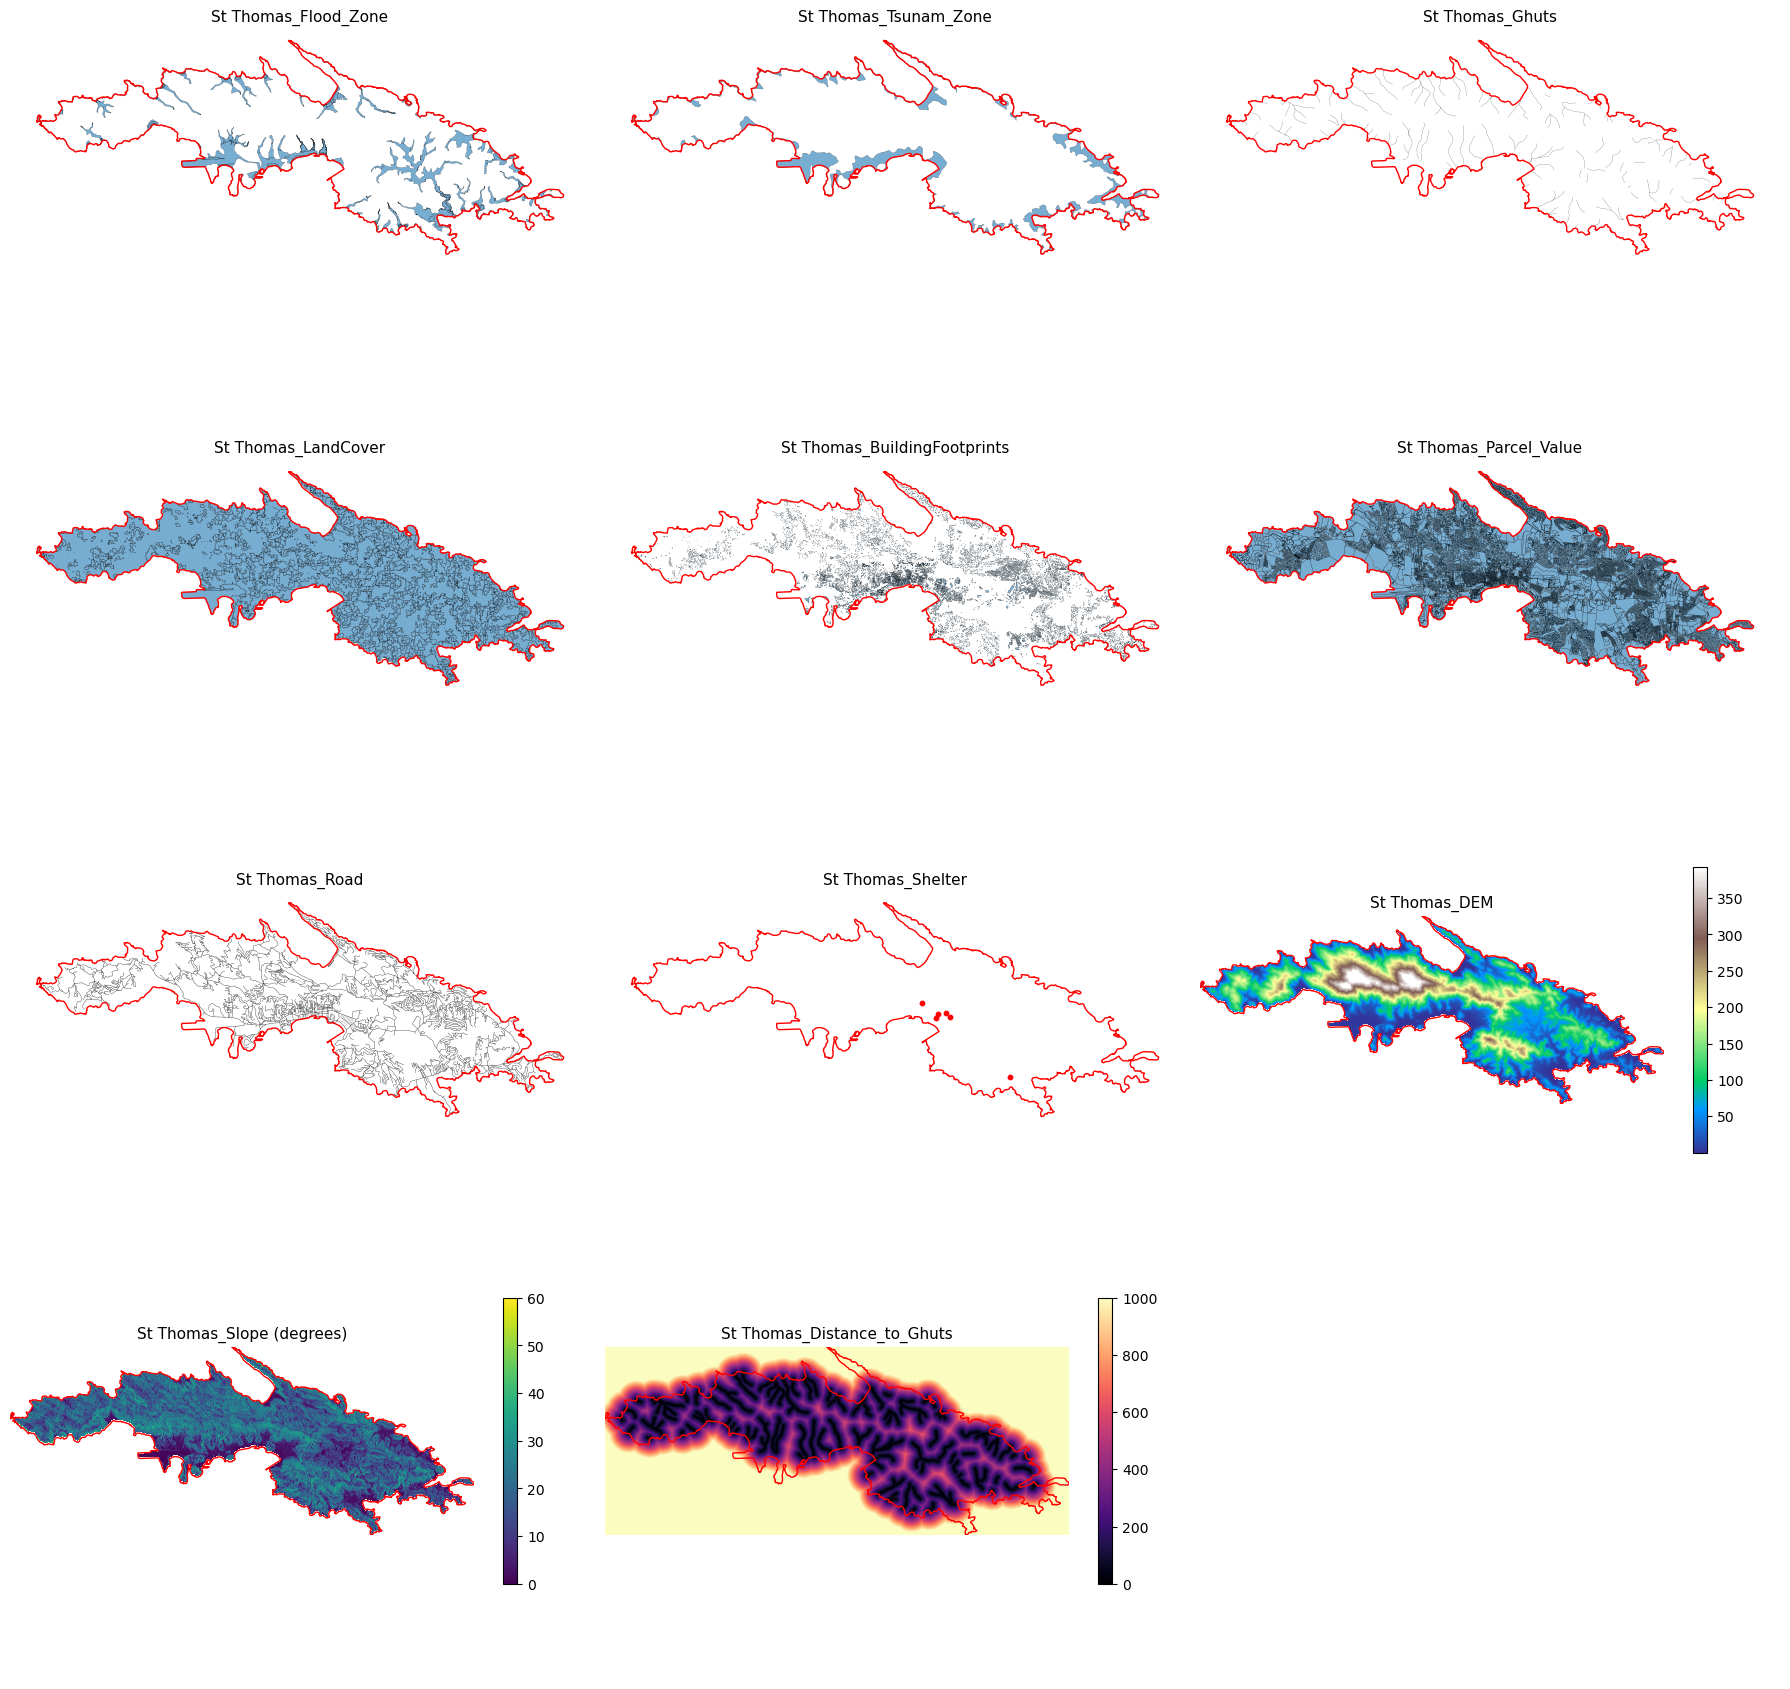

In [45]:
import math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from shapely import make_valid

images_dir = Path("images")
images_dir.mkdir(exist_ok=True)

# Paths
data_dir = Path("data")
processed = data_dir / "processed"
target_crs = "EPSG:3857"

# Load boundary
boundary = gpd.read_file(processed / "st_thomas_boundary.geojson").to_crs(target_crs)
boundary_union = boundary.unary_union

# Load and clip shelters
shelters = gpd.read_file(data_dir / "Shelter.geojson").to_crs(target_crs)
shelters["geometry"] = shelters.geometry.apply(make_valid)
shelters = shelters[~shelters.geometry.is_empty]
shelters = gpd.clip(shelters, boundary_union)
shelters = shelters[~shelters.geometry.is_empty]
if "shelter_id" not in shelters.columns:
    shelters["shelter_id"] = shelters.index.astype(str)
if "name" not in shelters.columns:
    shelters["name"] = shelters.index.astype(str)

# Vector layers and titles (including roads)
vector_layers = [
    ("flood_zone_st_thomas_3857.gpkg",       "St Thomas_Flood_Zone"),
    ("tsunami_st_thomas_3857.gpkg",          "St Thomas_Tsunam_Zone"),
    ("ghuts_st_thomas_3857.gpkg",            "St Thomas_Ghuts"),
    ("landcover_st_thomas_3857.gpkg",        "St Thomas_LandCover"),
    ("buildings_st_thomas_3857.gpkg",        "St Thomas_BuildingFootprints"),
    ("parcel_value_st_thomas_3857.gpkg",     "St Thomas_Parcel_Value"),
    ("roads_st_thomas_3857.gpkg",            "St Thomas_Road"),
]

# Raster layers and titles
raster_layers = [
    (processed / "dem_st_thomas_3857.tif",          "St Thomas_DEM",              "terrain", None, None),
    (processed / "slope_degrees_3857.tif",          "St Thomas_Slope (degrees)",  "viridis", 0, 60),
    (processed / "ghut_distance_m_3857.tif",        "St Thomas_Distance_to_Ghuts","magma",   None, None),
]

# Total plots and layout (+1 for shelters)
n_plots = len(vector_layers) + len(raster_layers) + 1
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows))
axes = axes.ravel()

# Plot vectors
for ax, (fname, title) in zip(axes, vector_layers):
    gdf = gpd.read_file(processed / fname).to_crs(target_crs)
    gdf["geometry"] = gdf.geometry.apply(make_valid)
    gdf = gdf[~gdf.geometry.is_empty]
    gdf.clip(boundary_union).plot(ax=ax, alpha=0.6, edgecolor="k", linewidth=0.2)
    boundary.boundary.plot(ax=ax, color="red", linewidth=1)
    ax.set_title(title, fontsize=11)
    ax.set_axis_off()

# Plot shelters
ax_idx = len(vector_layers)
ax = axes[ax_idx]
shelters.plot(ax=ax, color="red", markersize=10, label="Shelters")
boundary.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("St Thomas_Shelter", fontsize=11)
ax.set_axis_off()

# Plot rasters (DEM uses percentile stretch)
for ax, (rpath, title, cmap, vmin, vmax) in zip(axes[ax_idx + 1:], raster_layers):
    with rasterio.open(rpath) as src:
        arr = src.read(1).astype("float32")
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        nd = src.nodata
    if nd is not None:
        arr[arr == nd] = np.nan
    arr[~np.isfinite(arr)] = np.nan

    # DEM: apply percentile stretch
    if "DEM" in title:
        vmin = np.nanpercentile(arr, 1)
        vmax = np.nanpercentile(arr, 99)

    img = ax.imshow(arr, extent=extent, origin="upper", cmap=cmap, vmin=vmin, vmax=vmax)
    boundary.boundary.plot(ax=ax, color="red", linewidth=1)
    ax.set_title(title, fontsize=11)
    ax.set_axis_off()
    fig.colorbar(img, ax=ax, shrink=0.6)

# Hide any unused axes
for ax in axes[n_plots:]:
    ax.axis("off")

plt.tight_layout()
out_path = images_dir / "datasource.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {out_path}")
